### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

from YearPlotter import YearPlotter
import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBBSSBB'
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
print df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12884
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     0|[20 50 40 4C 80 4...|1926.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     0|[00 00 A0 D3 00 0...|1927.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     1|[80 4D 80 D4 E0 D...|1928.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     1|[00 53 00 00 00 C...|1929.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     2|[E0 54 E0 55 00 4...|1930.0|BBBBSSBB|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')

Query="SELECT max(elevation) as max,min(elevation) as min "\
      "FROM weather where measurement = 'TOBS'"
dfx = sqlContext.sql(Query)

mx=dfx.rdd.map(lambda row:(row[0],row[1])).collect()
mx

[(573.0, 36.3)]

In [3]:
def get_groups(meas):
    sqlContext.registerDataFrameAsTable(df,'weatherl')
    Query="SELECT * FROM weatherl WHERE measurement = '{0}'".format(meas)
    print Query
    dfl = sqlContext.sql(Query)

    rows2=dfl.rdd.map(lambda row:row['elevation']).collect()
    EL=np.vstack(rows2)
    #print shape(EL)
    return EL

In [4]:
def get_elbow(m, EL):
    ax = plt.gca()
    n_init_list = np.arange(1,30,1)
    inertia = []

    for n in n_init_list: 
        k_means = KMeans(n_clusters=5, n_init=n, init='random', random_state=5) 
        k_means.fit(EL)
        inertia.append(k_means.inertia_)

    ax.plot(n_init_list, inertia)
    plt.title("{0} elbow method for determining # of clusters".format(m))
    ax.patch.set_facecolor('lightyellow')
    plt.show()

In [5]:
def get_centers(n_clusters, EL, meas):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    kmeans.fit(EL)
    centers = kmeans.cluster_centers_
    print "{0} - K-means centers are:\n {1}".format(meas, sorted(centers))
    return kmeans

In [6]:
def do_chart(EL, meas, centers):
    gmx = GaussianMixture()
    gmx.fit(EL)
    colors = ['r' if i==0 else 'g' for i in gmx.predict(EL)]
    size=60
    ax = plt.gca()
    ax.scatter(EL, [0 for i in range(len(EL))], c=colors, alpha=0.8, s=size)

    for i in range(len(centers)):
        ax.scatter(centers[i],0, marker='X', color='b', s=size*2)

    ax.xaxis.limit_range_for_scale(-.4, .3)
    plt.title('{0} Elevation Cluster Centers in meters'.format(meas))
    ax.patch.set_facecolor('lightblue')
    plt.show()

In [7]:
from numpy import linalg as LA
MEAS = dict()
STAT={}

def get_stats(kmeans, meas, EL):
    global MEAS
    global STAT
    
    labels = dict()
    MEAS.update({meas:[]})
    
    for l, v in zip(kmeans.labels_,EL):
        if v[0] not in labels:
            labels.update({v[0]:l})
            MEAS[meas].append(l)
        
    MEAS[meas] = list(set(MEAS[meas]))

    for n in MEAS[meas]:
        measure = "{0}{1}".format(meas,n)
        elev = []
            
        for l in labels:
            if labels[l] == n:
                elev.append(l)
            
        elev = ",".join([str(x) for x in list(set(elev))])
    
        try:
            Query="SELECT * FROM weather WHERE measurement = '{0}' "\
                  "and elevation in ({1})".format(meas,elev)
            #print Query
            dft = sqlContext.sql(Query)
            data=dft.rdd.map(lambda row: unpackArray(row['vector'],np.float16))
    
            STAT[measure]=computeOverAllDist(data)   # Compute the statistics 
            
            # compute covariance matrix
            OUT=computeCov(data)

            #find PCA decomposition
            eigval,eigvec=LA.eig(OUT['Cov'])

            # collect all of the statistics in STAT[meas]
            STAT[measure]['eigval']=eigval
            STAT[measure]['eigvec']=eigvec
            STAT[measure].update(OUT)
        except:
            print "{0} error".format(measure)


SELECT * FROM weatherl WHERE measurement = 'TMAX'
(1985, 1)


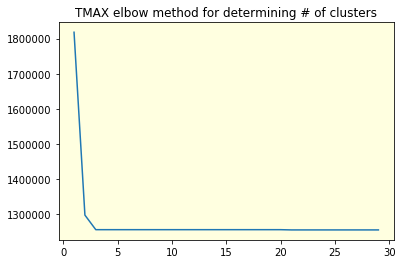

SELECT * FROM weatherl WHERE measurement = 'SNOW'
(2198, 1)


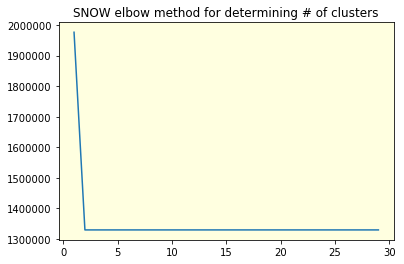

SELECT * FROM weatherl WHERE measurement = 'TMIN'
(1977, 1)


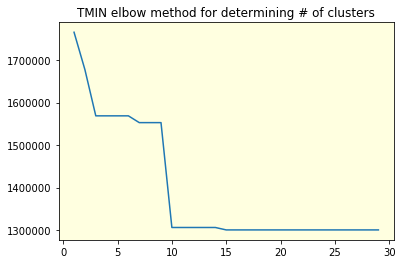

SELECT * FROM weatherl WHERE measurement = 'PRCP'
(3837, 1)


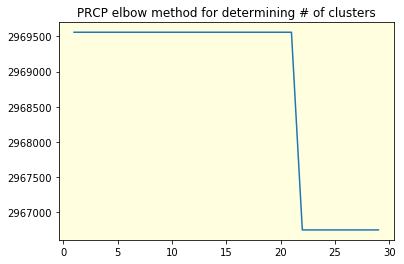

SELECT * FROM weatherl WHERE measurement = 'TOBS'
(1421, 1)


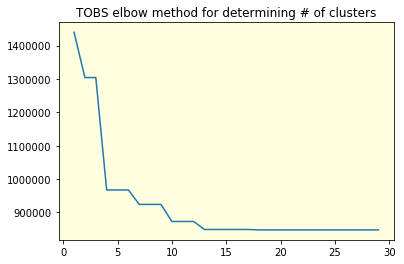

In [8]:
measurements=['TMAX', 'SNOW', 'TMIN', 'PRCP', 'TOBS']
ELS = []

for m in measurements:
    EL = get_groups(m)
    ELS.append((m, EL))
    get_elbow(m, EL)

In [9]:
ks = (2,2,10,22,4)

for i in range(len(ELS)):
    m, EL = ELS[i]
    kmeans = get_centers(ks[i], EL, m)
    get_stats(kmeans, m, EL)


TMAX - K-means centers are:
 [array([ 148.41427487]), array([ 484.83128743])]
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
SNOW - K-means centers are:
 [array([ 164.85747978]), array([ 489.21092437])]
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
TMIN - K-means centers are:
 [array([ 40.23764706]), array([ 113.37012302]), array([ 152.134375]), array([ 195.16122449]), array([ 258.28688525]), array([ 333.33055556]), array([ 420.51466667]), array([ 468.99565217]), array([ 507.3256705]), array([ 540.53641618])]
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
shape of E= (365,) shape of NE= (365,)
PRCP - K-means centers are:
 [ar

TOBS - K-means centers are:
 [array([ 37.81578947]), array([ 140.31314935]), array([ 280.71176471]), array([ 499.40905512])]


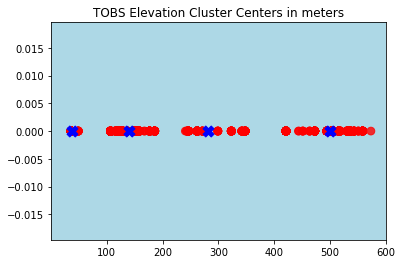

In [10]:
m, EL = ELS[4]
kmeans = get_centers(4, EL, m)
do_chart(EL, 'TOBS', kmeans.cluster_centers_)

In [11]:
YP=YearPlotter()

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [12]:
def plot_pair(pair,func,c=0,labels=None):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis,c,labels)
        
def plot_valid(m,fig,axis,c,labels=None):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title=m+' valid-counts',label=labels)

### Plots of mean and std of observations

In [13]:
allmeas=sorted(STAT.keys())
allmeas

['PRCP0',
 'PRCP1',
 'PRCP10',
 'PRCP11',
 'PRCP12',
 'PRCP13',
 'PRCP14',
 'PRCP15',
 'PRCP16',
 'PRCP17',
 'PRCP18',
 'PRCP19',
 'PRCP2',
 'PRCP20',
 'PRCP21',
 'PRCP3',
 'PRCP4',
 'PRCP5',
 'PRCP6',
 'PRCP7',
 'PRCP8',
 'PRCP9',
 'SNOW0',
 'SNOW1',
 'TMAX0',
 'TMAX1',
 'TMIN0',
 'TMIN1',
 'TMIN2',
 'TMIN3',
 'TMIN4',
 'TMIN5',
 'TMIN6',
 'TMIN7',
 'TMIN8',
 'TMIN9',
 'TOBS0',
 'TOBS1',
 'TOBS2',
 'TOBS3']

In [14]:
def plot_mean_std(m,fig,axis,c,labels=None):
    mean=STAT[m]['Mean']/10.*2-4+32
    std=np.sqrt(STAT[m]['Var'])/10.*2-4+32

    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title=m+' Mean+-std',labels=labels)

### Script for plotting percentage of variance explained

In [15]:
def pltVarExplained(j,m,c):
    global STAT
    subplot(1,c,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

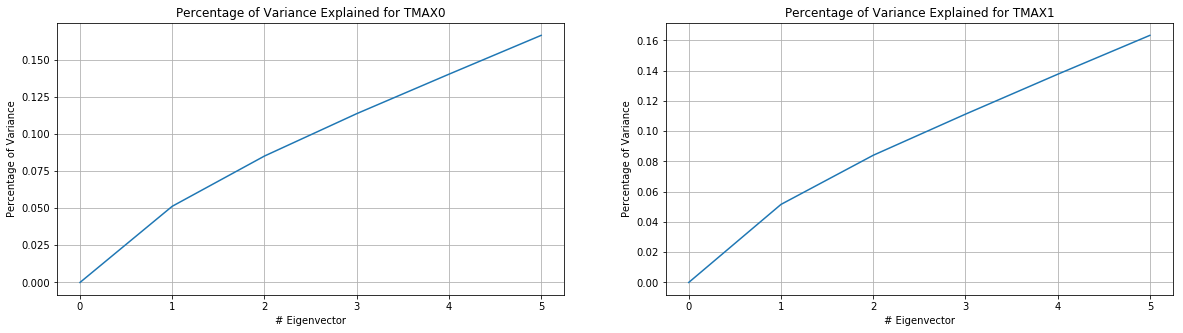

In [16]:
f=plt.figure(figsize=(20,5))
j=1
for m in ['TMAX0','TMAX1']:
    pltVarExplained(j,m,2)
    j+=1

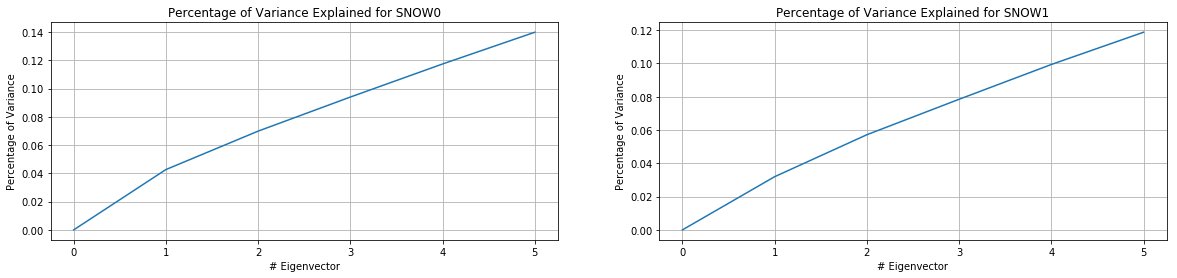

In [17]:
f=plt.figure(figsize=(20,4))
j=1
for m in ['SNOW0','SNOW1']:
    pltVarExplained(j,m,2)
    j+=1

/Users/jc/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


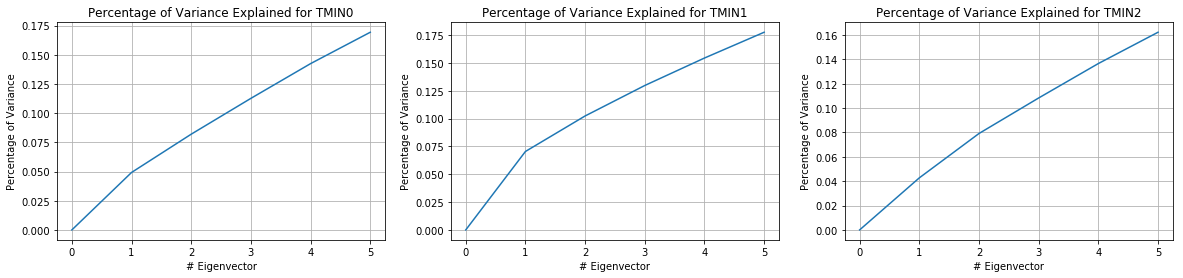

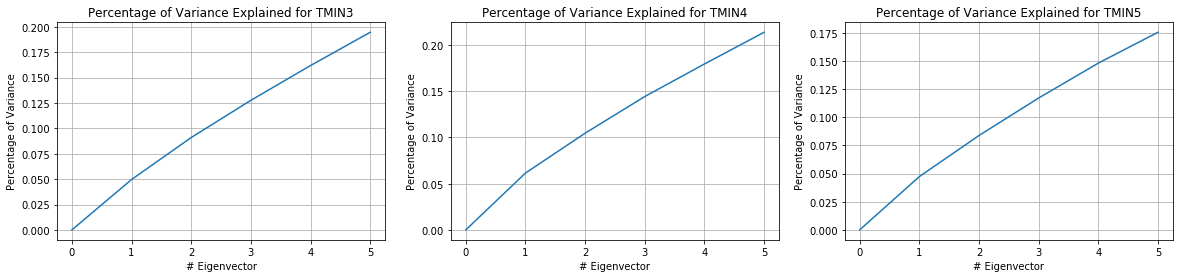

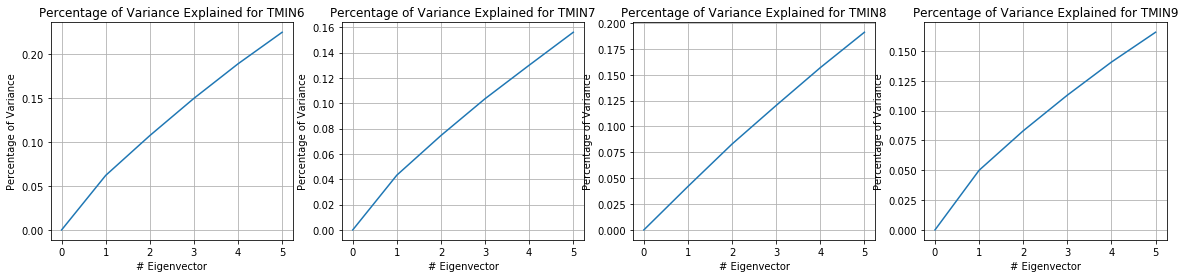

In [18]:
f=plt.figure(figsize=(20,4))
j=1
for m in ['TMIN0','TMIN1','TMIN2']:
    pltVarExplained(j,m,3)
    j+=1

f=plt.figure(figsize=(20,4))
j=1
for m in ['TMIN3','TMIN4','TMIN5']:
    pltVarExplained(j,m,3)
    j+=1

f=plt.figure(figsize=(20,4))
j=1
for m in ['TMIN6','TMIN7','TMIN8','TMIN9']:
    pltVarExplained(j,m,4)
    j+=1

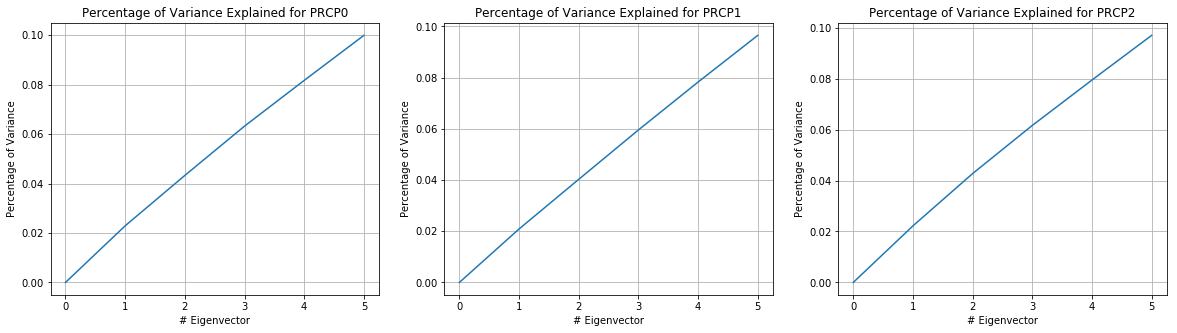

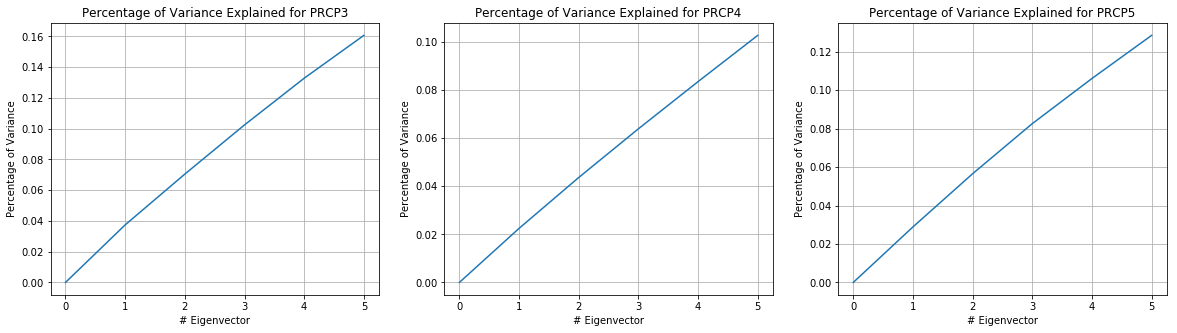

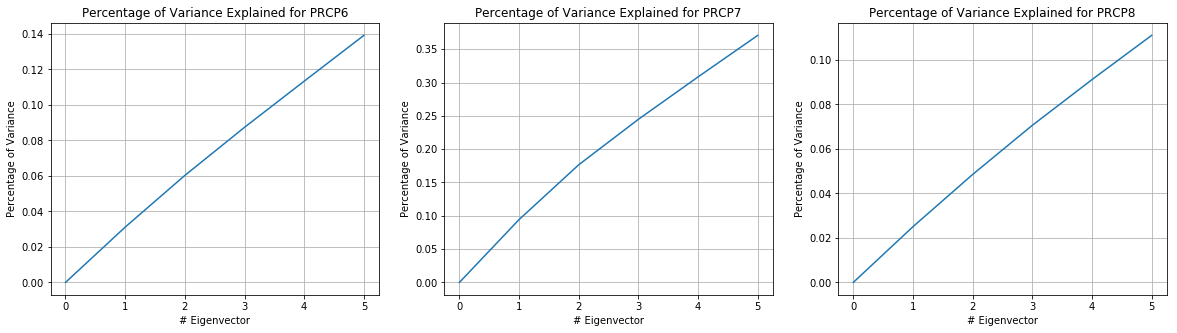

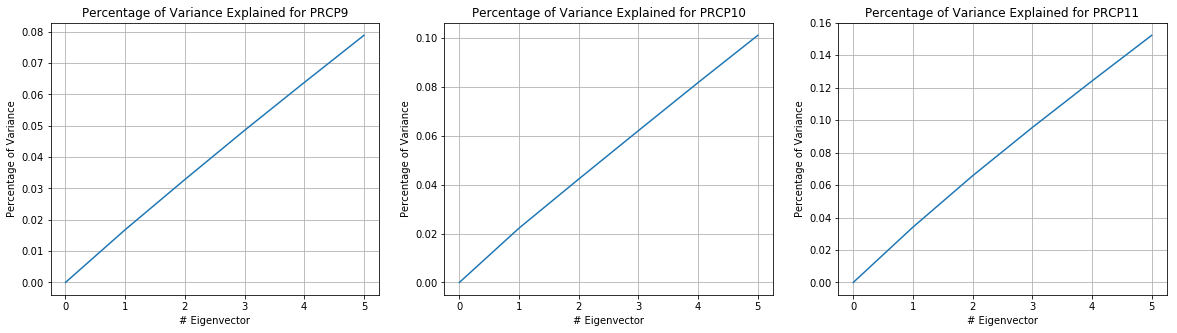

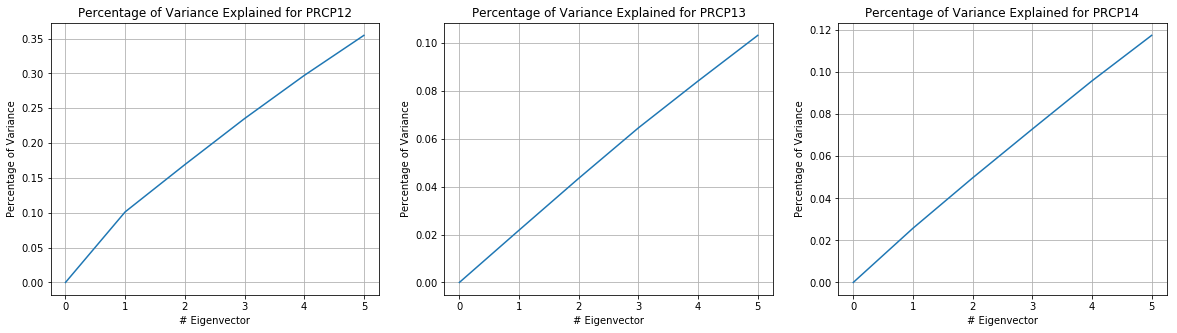

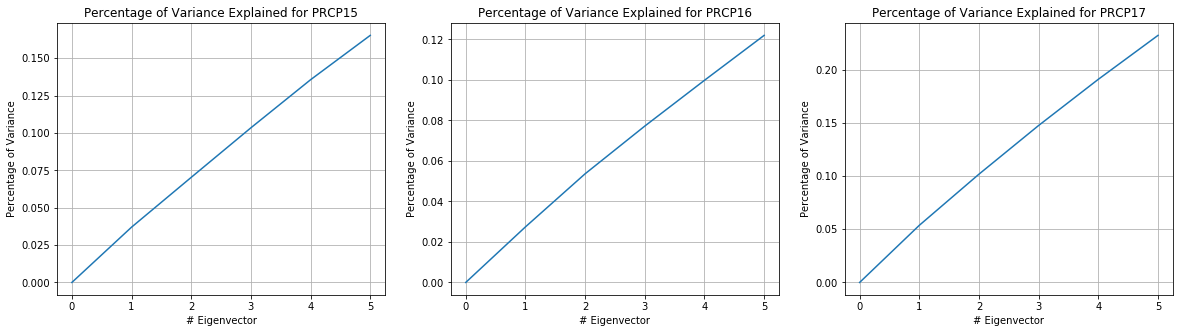

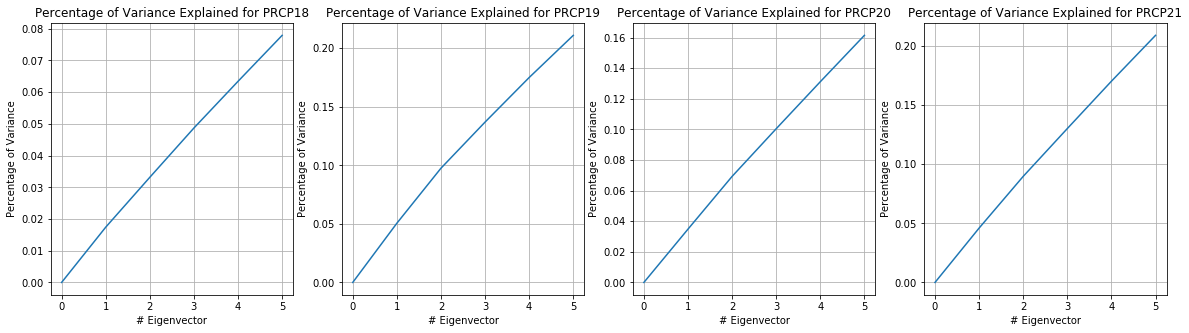

In [19]:
f=plt.figure(figsize=(20,5))
j=1
for m in ['PRCP0','PRCP1','PRCP2']:
    pltVarExplained(j,m,3)
    j+=1

f=plt.figure(figsize=(20,5))
j=1
for m in ['PRCP3','PRCP4','PRCP5']:
    pltVarExplained(j,m,3)
    j+=1

f=plt.figure(figsize=(20,5))
j=1
for m in ['PRCP6','PRCP7','PRCP8']:
    pltVarExplained(j,m,3)
    j+=1

f=plt.figure(figsize=(20,5))
j=1
for m in ['PRCP9','PRCP10','PRCP11']:
    pltVarExplained(j,m,3)
    j+=1

f=plt.figure(figsize=(20,5))
j=1
for m in ['PRCP12','PRCP13','PRCP14']:
    pltVarExplained(j,m,3)
    j+=1

f=plt.figure(figsize=(20,5))
j=1
for m in ['PRCP15','PRCP16','PRCP17']:
    pltVarExplained(j,m,3)
    j+=1

f=plt.figure(figsize=(20,5))
j=1
for m in ['PRCP18','PRCP19','PRCP20','PRCP21']:
    pltVarExplained(j,m,4)
    j+=1

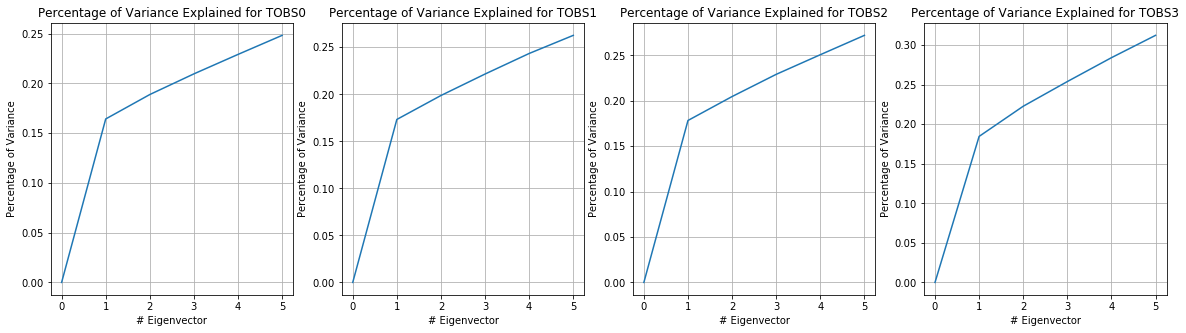

In [20]:
f=plt.figure(figsize=(20,5))
j=1
for m in ['TOBS0','TOBS1','TOBS2','TOBS3']:
    pltVarExplained(j,m,4)
    j+=1

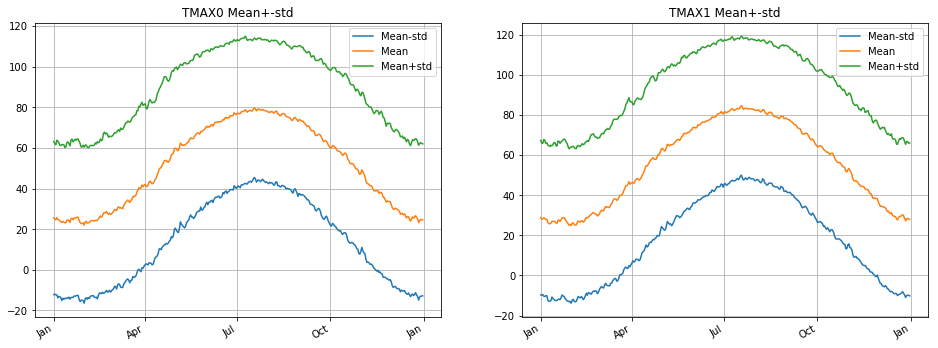

In [21]:
plot_pair(['TMAX0','TMAX1'],plot_mean_std,0,['Mean-std','Mean','Mean+std'])

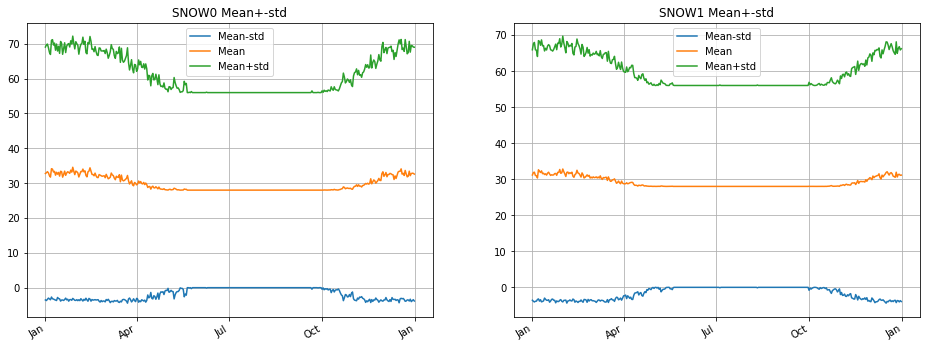

In [22]:
plot_pair(['SNOW0','SNOW1'],plot_mean_std,0,['Mean-std','Mean','Mean+std'])

In [23]:
def plot_mean(m,fig,axis,label):
    mean=STAT[m]['Mean']/10.0*2-4+32
    YP.plot(mean,fig,axis,title=m+' Mean',label=label)

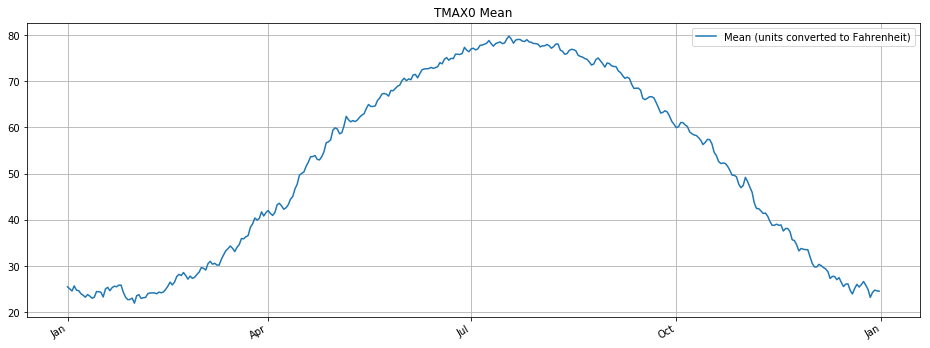

In [24]:
fig,X=subplots(1,1,figsize=(16,6))
plot_mean('TMAX0',fig,X,'Mean (units converted to Fahrenheit)')

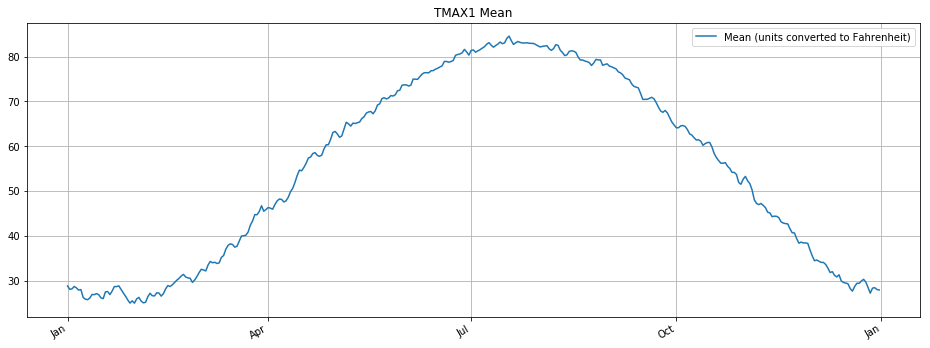

In [25]:
fig,X=subplots(1,1,figsize=(16,6))
plot_mean('TMAX1',fig,X,'Mean (units converted to Fahrenheit)')

#### plotting top 3 eigenvectors

In [26]:
def plot_eigen(m,fig,axis,c=3,labels=None):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:c],fig,axis,title=m+' Top Eigenvectors',labels=labels)

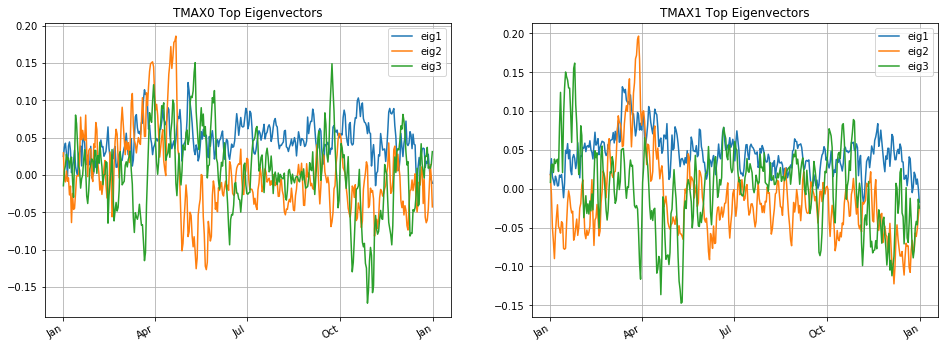

In [27]:
plot_pair(['TMAX0','TMAX1'],plot_eigen,3,['eig1','eig2','eig3'])

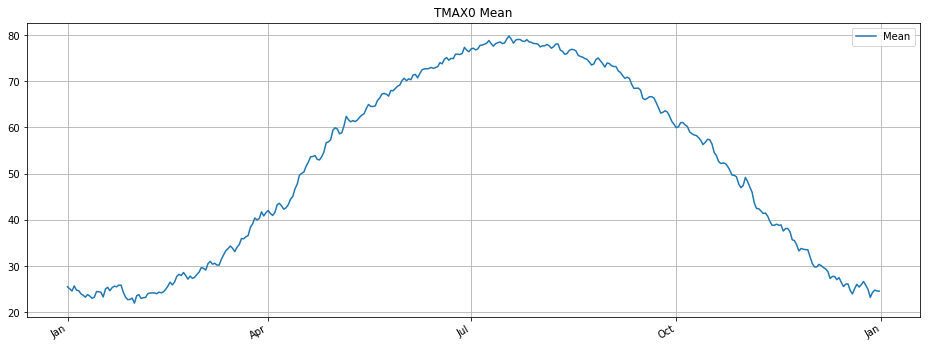

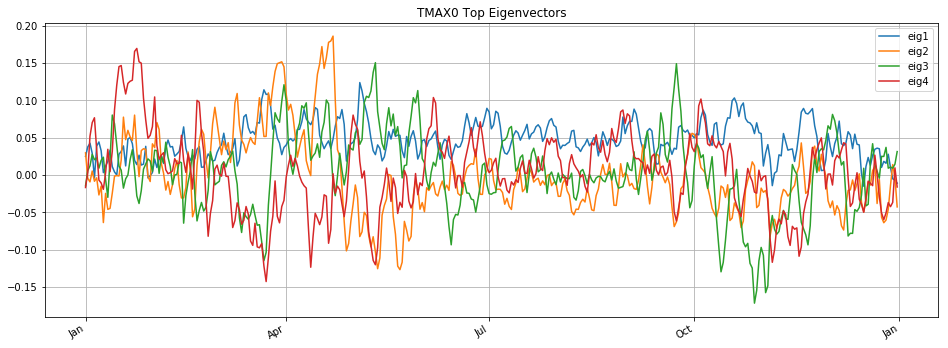

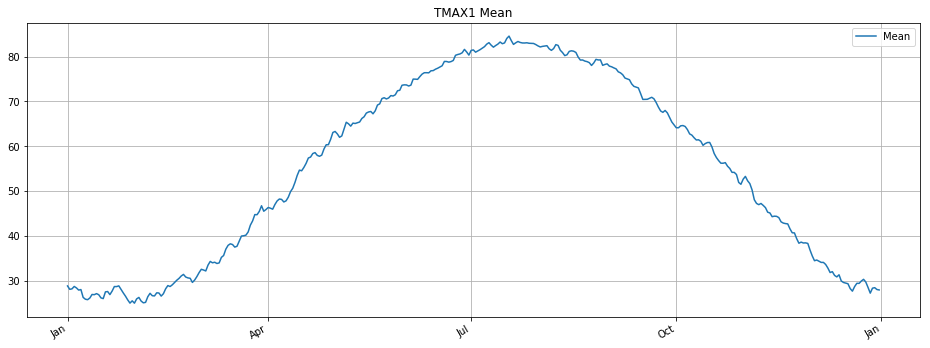

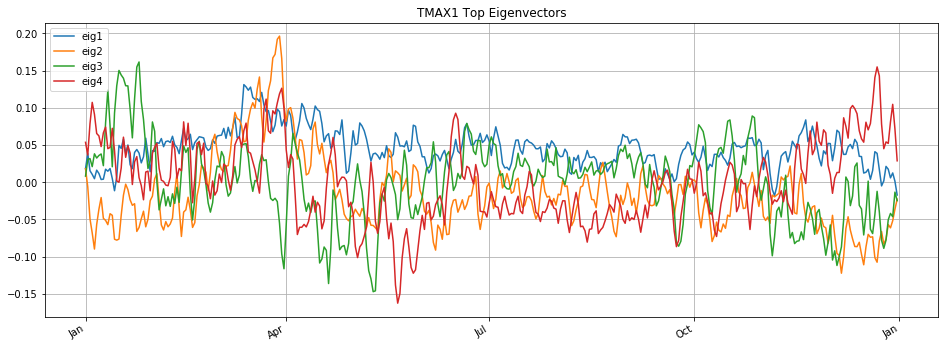

In [28]:

for o in ['TMAX0','TMAX1']:
    fig,X=subplots(1,1,figsize=(16,6))
    plot_mean(o,fig,X,'Mean')
    fig,X=subplots(1,1,figsize=(16,6))
    plot_eigen(o,fig,X,4,['eig1','eig2','eig3','eig4'])

In [29]:
#sc.stop()